In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.getcwd()

'/raid/infolab/prateekgarg/work/tiny-discrete-diffusion'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils

In [3]:
import torchvision
import torchvision.transforms as transforms

N_TOKENS = 5
RESOLUTION = 14 # 10x10 images
if os.path.exists(f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt') == False:
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((RESOLUTION, RESOLUTION))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    MAX_BATCH_SIZE = max(len(trainset), len(testset))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=MAX_BATCH_SIZE, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=MAX_BATCH_SIZE, shuffle=False)

    for i, data in enumerate(trainloader, 0):
        train_images, train_labels = data
        break

    for i, data in enumerate(testloader, 0):
        test_images, test_labels = data
        break

    data_min = train_images.min()
    data_max = train_images.max()

    train_images, token_vals = utils.discretize_data( train_images, N_TOKENS, data_max=data_max, data_min=data_min)
    test_images, token_vals = utils.discretize_data( test_images, N_TOKENS, data_max=data_max, data_min=data_min)
    os.makedirs('data/processed/MNIST', exist_ok=True)
    torch.save(train_images, f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    torch.save(train_labels, 'data/processed/MNIST/train_labels.pt')
    torch.save(test_images, f'data/processed/MNIST/test_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    torch.save(test_labels, 'data/processed/MNIST/test_labels.pt')
    torch.save(token_vals, f'data/processed/MNIST/token_vals_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')

else:
    train_images = torch.load(f'data/processed/MNIST/train_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    train_labels = torch.load('data/processed/MNIST/train_labels.pt')
    test_images = torch.load(f'data/processed/MNIST/test_images_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')
    test_labels = torch.load('data/processed/MNIST/test_labels.pt')
    token_vals = torch.load(f'data/processed/MNIST/token_vals_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt')

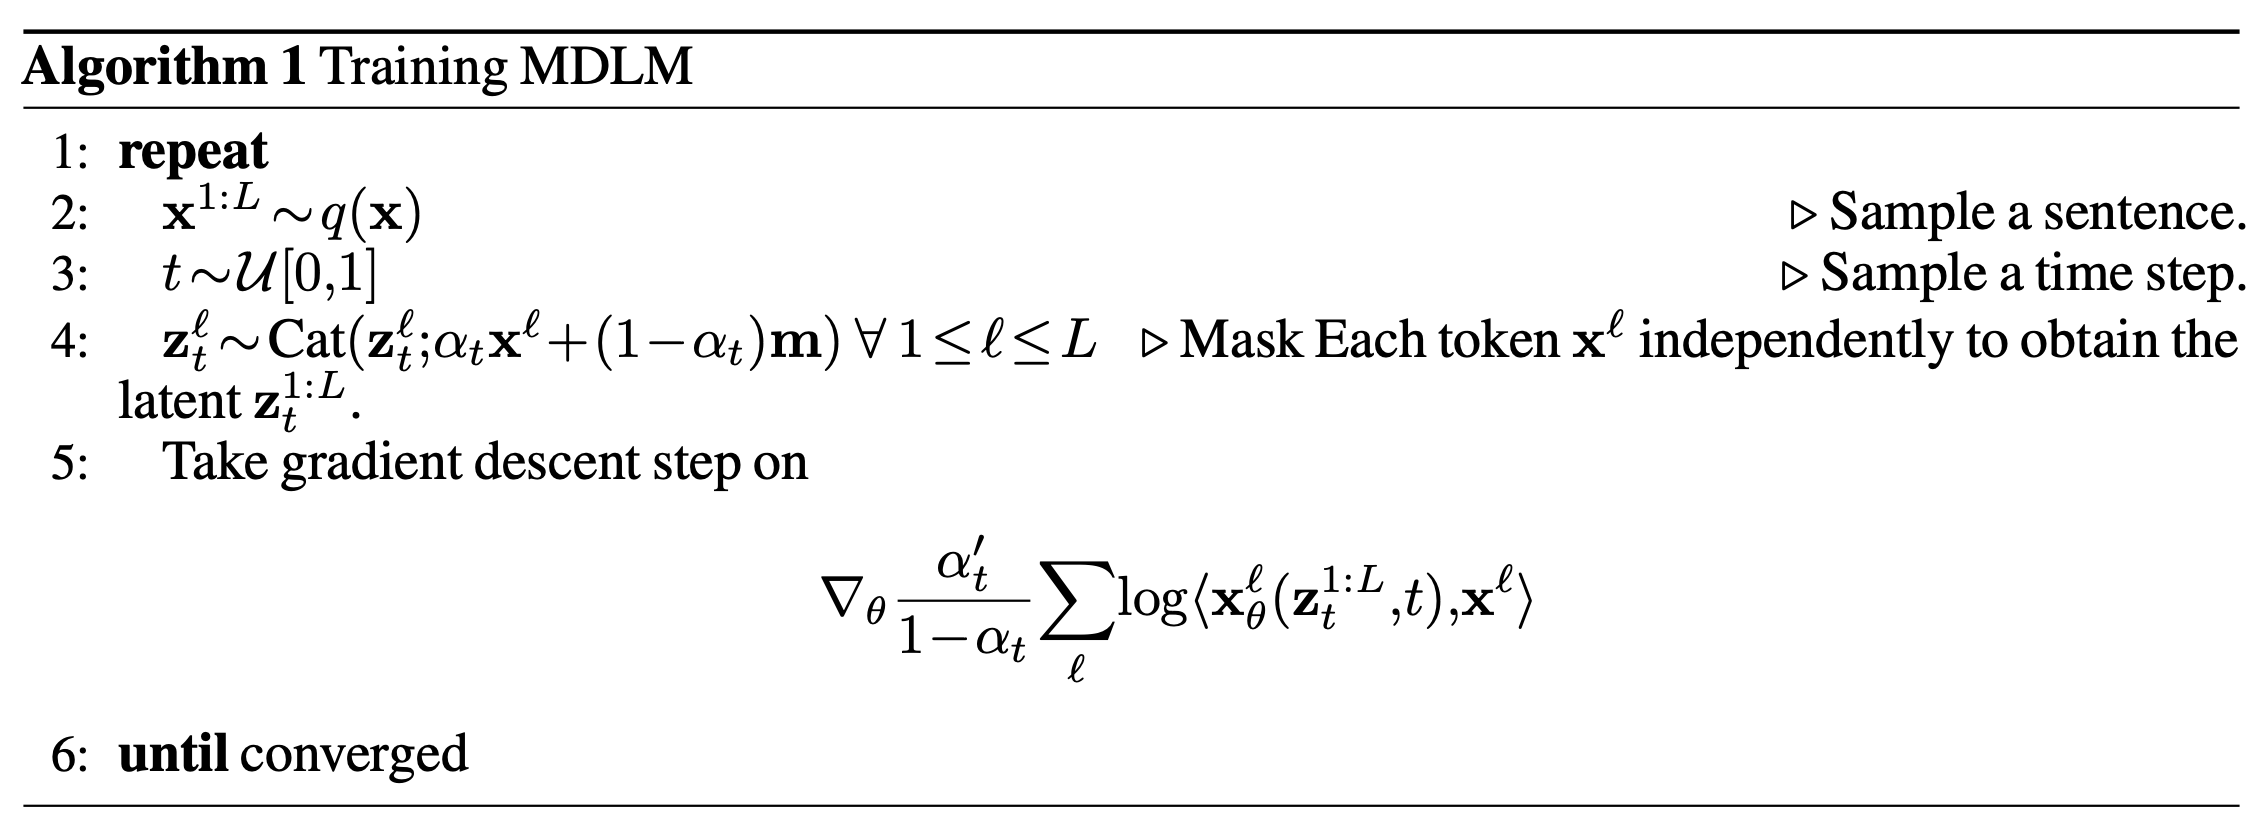

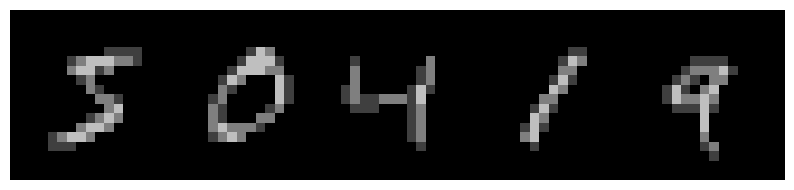

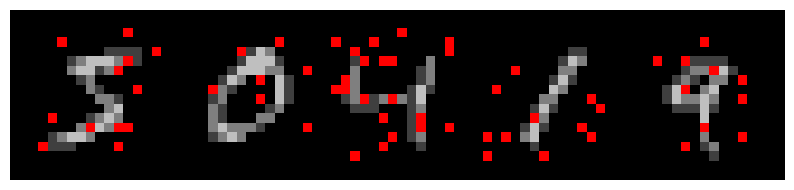

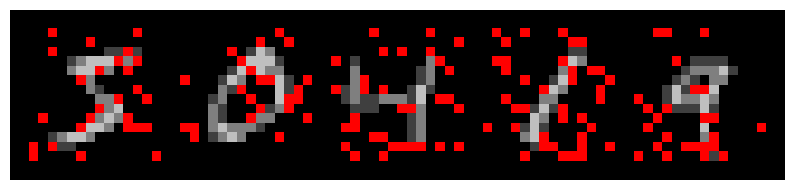

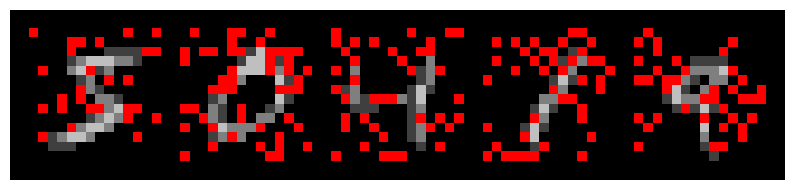

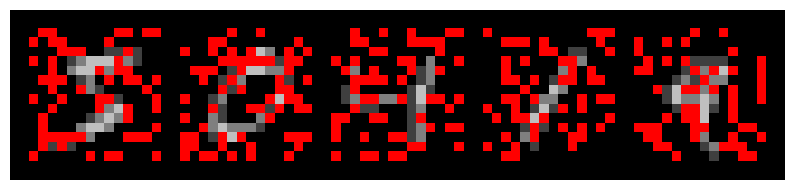

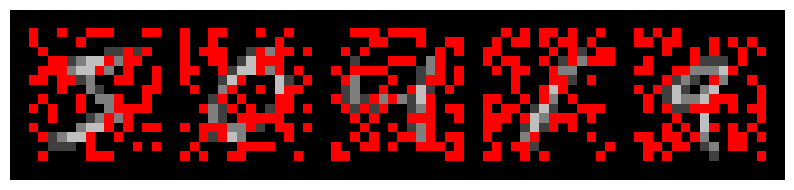

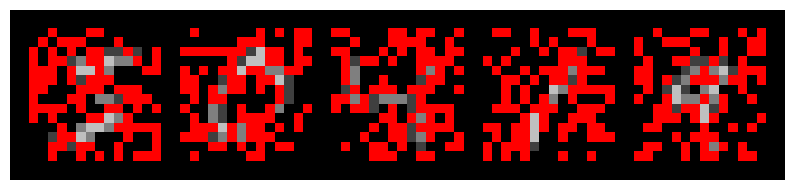

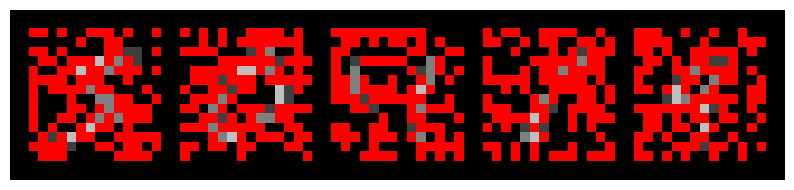

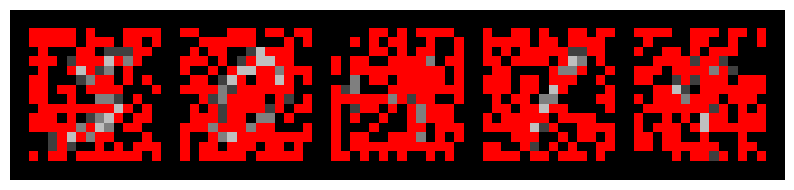

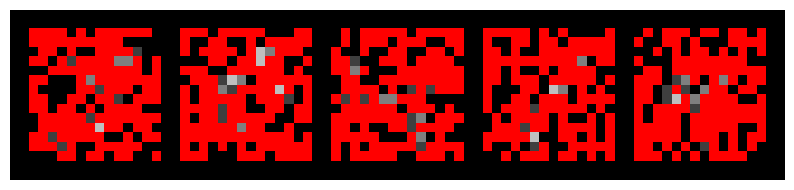

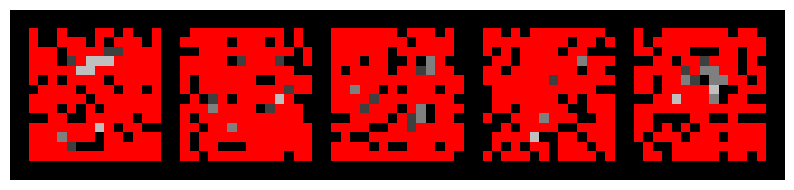

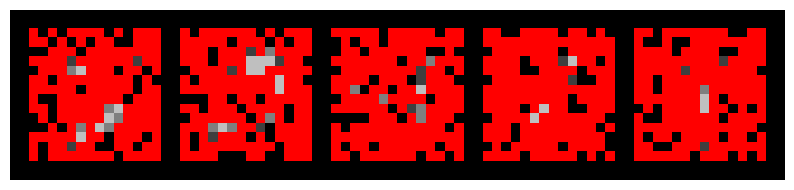

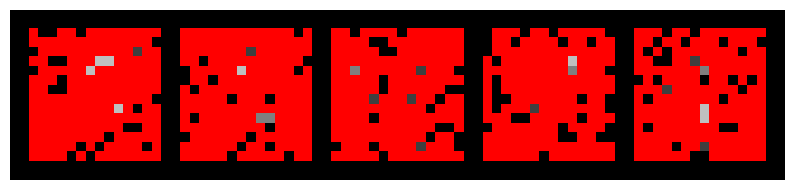

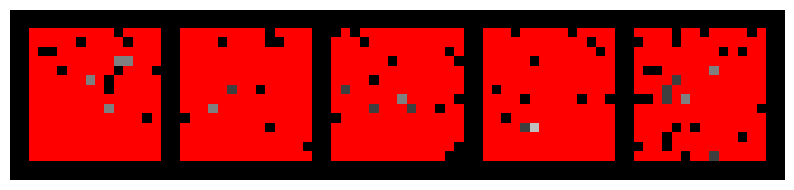

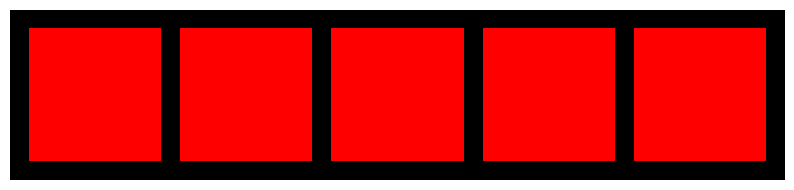

In [9]:
tokenized_images = train_images[:5]
for t in torch.linspace(0,1,15):
    masks = torch.rand_like(tokenized_images, dtype=torch.float) < 1 - masking_sch.get_alpha(t)
    masked_tokenized_images = torch.where(masks, torch.tensor(N_TOKENS, device=tokenized_images.device), tokenized_images)

    # detokenize
    gray_values = token_vals[tokenized_images]
    colored_images = gray_values.repeat(1,3, 1, 1)

    utils.viz_masked_images(colored_images, masks, nrow=5)

In [5]:
train_tokens = train_images.reshape(len(train_images), -1).long()
test_tokens = test_images.reshape(len(test_images), -1).long()
# train_tokens.reshape(len(train_tokens), 1,RESOLUTION, RESOLUTION) to recover
train_tokens.shape, test_tokens.shape

(torch.Size([60000, 196]), torch.Size([10000, 196]))

In [25]:
train_tokens[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2,
        3, 3, 3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

class TimeEncoding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.freqs = nn.Parameter(torch.exp(torch.linspace(0, 6, embed_dim // 2))) 

    def forward(self, t):
        t = t.unsqueeze(-1) * self.freqs  
        return torch.cat([t.sin(), t.cos()], dim=-1)  
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Batch First, unnecassarily convoluted but works as expected
        x = x + self.pe[: x.size(1), :].view(1, x.size(1), -1)
        return self.dropout(x)

class Unmasker(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=4, hidden_dim=256, dropout=0.1, n_dim = RESOLUTION**2):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_dim = n_dim
        self.tim_embed = TimeEncoding(embed_dim)
        self.tok_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, dropout=dropout, max_len=n_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, t):
        x = self.pos_embed(self.tok_embed(x)) + self.tim_embed(t)
        x = self.encoder(x)
        return self.output_layer(x)

In [7]:
class MaskingScheduler:
    def __init__(self, mode = "linear"):
        self.mode = mode
        self.eps = 1e-6
        self.init_linear_scheduler()
    def init_linear_scheduler(self):
        self.alpha = lambda t : 1 - t
        self.ce_weight = lambda t : -1/(t + self.eps) 

    @torch.no_grad()
    def get_alpha(self, t):
        return self.alpha(t)
    
    @torch.no_grad()
    def get_ce_weight(self, t):
        return self.ce_weight(t)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unmasker(N_TOKENS + 1, embed_dim=32, num_heads=8, num_layers=8, hidden_dim=16, dropout=0.3, n_dim = RESOLUTION**2).to(device)
# model = Unmasker(N_TOKENS + 1, embed_dim=64, num_heads=8, num_layers=16, hidden_dim=62, dropout=0.3, n_dim = RESOLUTION**2).to(device)
masking_sch = MaskingScheduler()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
loss_fn = nn.CrossEntropyLoss()
N_EPOCHS = 20000
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_tokens), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_tokens), batch_size=BATCH_SIZE, shuffle=False)
losses = {
    "train": [],
    "test" : []
}

for epoch in range(N_EPOCHS):
    model.train()
    epoch_train_loss = 0 
    batch_count = 0
    for i, (tokens,) in enumerate(train_loader):
        tokens = tokens.to(device)
        time_steps = torch.rand(tokens.shape[0], dtype=torch.float).reshape(-1,1).repeat(1, tokens.shape[1]).to(tokens.device)
        alpha_t = masking_sch.get_alpha(time_steps).to(device)
        ce_weight_t = masking_sch.get_ce_weight(time_steps).to(device)
        masks = torch.rand_like(tokens, dtype=torch.float, device=device) < 1 - alpha_t
        masked_tokens = torch.where(masks, torch.tensor(N_TOKENS, device=tokens.device), tokens) 
        pred = model(masked_tokens, time_steps)

        logprob = torch.log_softmax(pred, dim=-1)
        loss = (logprob[torch.arange(logprob.shape[0]).reshape(-1,1),torch.arange(logprob.shape[1]), tokens] * ce_weight_t * masks).sum(dim=-1).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(tokens)
        batch_count += len(tokens)

        # if i % 100 == 0:
        # print(f"Epoch {epoch}, Batch {i}, Loss {loss.item()}")
    losses["train"].append(epoch_train_loss / batch_count)
    print(f"Epoch {epoch}, Train Loss {losses['train'][-1] :.03f}")

    epoch_test_loss = 0
    test_batch_count = 0

    if epoch % 1 == 0:
        os.makedirs('saved_models', exist_ok=True)
        torch.save(model.state_dict(), f"saved_models/unmasker_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt")
        model.eval()
        with torch.no_grad():
            for i, (tokens,) in enumerate(test_loader):
                tokens = tokens.to(device)
                time_steps = torch.rand(tokens.shape[0], dtype=torch.float, device=device).reshape(-1,1).repeat(1, tokens.shape[1]).to(tokens.device)
                alpha_t = masking_sch.get_alpha(time_steps).to(device)
                ce_weight_t = masking_sch.get_ce_weight(time_steps).to(device)
                masks = torch.rand_like(tokens, dtype=torch.float, device=device) < alpha_t
                masked_tokens = torch.where(masks, torch.tensor(N_TOKENS, device=tokens.device), tokens) 
                pred = model(masked_tokens, time_steps)

                logprob = torch.log_softmax(pred, dim=-1)
                loss = (logprob[torch.arange(logprob.shape[0]).reshape(-1,1),torch.arange(logprob.shape[1]), tokens] * ce_weight_t).sum(dim=-1).mean()
                epoch_test_loss += loss.item() * len(tokens)
                test_batch_count += len(tokens)
        losses["test"].append(epoch_test_loss / test_batch_count)
        print(f"Epoch {epoch}, Test  Loss {losses['test'][-1]:.03f}")


Epoch 0, Train Loss 485.765
Epoch 0, Test  Loss 4304.973
Epoch 1, Train Loss 479.125
Epoch 1, Test  Loss 30763.869
Epoch 2, Train Loss 474.929
Epoch 2, Test  Loss 8152.484
Epoch 3, Train Loss 469.304
Epoch 3, Test  Loss 26909.096
Epoch 4, Train Loss 463.545
Epoch 4, Test  Loss 4636.491
Epoch 5, Train Loss 459.769
Epoch 5, Test  Loss 4570.343
Epoch 6, Train Loss 454.193
Epoch 6, Test  Loss 5669.161
Epoch 7, Train Loss 449.617
Epoch 7, Test  Loss 3409.230
Epoch 8, Train Loss 444.561
Epoch 8, Test  Loss 4805.726
Epoch 9, Train Loss 439.037
Epoch 9, Test  Loss 5898.027
Epoch 10, Train Loss 434.999
Epoch 10, Test  Loss 3863.795
Epoch 11, Train Loss 429.872
Epoch 11, Test  Loss 3925.893
Epoch 12, Train Loss 425.532
Epoch 12, Test  Loss 5266.672
Epoch 13, Train Loss 420.650
Epoch 13, Test  Loss 7022.319
Epoch 14, Train Loss 416.978
Epoch 14, Test  Loss 5861.218
Epoch 15, Train Loss 412.540
Epoch 15, Test  Loss 8228.682
Epoch 16, Train Loss 407.771
Epoch 16, Test  Loss 3689.855
Epoch 17, Train

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unmasker(N_TOKENS + 1, embed_dim=32, num_heads=8, num_layers=8, hidden_dim=16, dropout=0.3, n_dim = RESOLUTION**2).to(device)
masking_sch = MaskingScheduler()
model.load_state_dict(torch.load(f"saved_models/final_unmasker_{N_TOKENS}_{RESOLUTION}x{RESOLUTION}.pt"))

<All keys matched successfully>

In [26]:
def multinomial_sample(prob_tensor):
    # prob_tensor is assumed to be (..., n) tensor
    # returns a tensor of indices of shape ... that are sampled from multinomial
    n = prob_tensor.shape[-1]
    remaining_shape = prob_tensor.shape[:-1]
    flat_samples = torch.multinomial(prob_tensor.reshape(-1, n), 1).squeeze(-1)
    return flat_samples.reshape(remaining_shape)

@torch.no_grad()
def sample(model, n_samples, n_steps, device, masking_sch):
    model.eval()
    MASK_IDX = model.vocab_size - 1
    samples = torch.zeros(n_samples, model.n_dim, dtype=torch.long, device=device) + MASK_IDX
    time_steps = torch.linspace(0, 1, n_steps+1, device=device)
    for i in range(n_steps,0,-1):
        t = time_steps[i].repeat(n_samples, model.n_dim)
        s = time_steps[i-1].repeat(n_samples, model.n_dim)
        as_ = masking_sch.get_alpha(s).to(device)
        at_ = masking_sch.get_alpha(t).to(device)
        mu_ = torch.softmax(model(samples, t), dim=-1)
        c1 = (as_ - at_) / (1 - at_)
        c2 = (1 - as_) / (1 - at_)
        cat_probs = mu_ * c1[...,None]
        cat_probs[...,MASK_IDX] += c2
        proposed_tokens = multinomial_sample(cat_probs)
        samples[samples == MASK_IDX] = proposed_tokens[samples == MASK_IDX]
    return samples.cpu()

tokenized_samples = sample(model, 5,100, device, masking_sch)

In [27]:
images = token_vals[tokenized_samples.reshape(len(tokenized_samples), 1,RESOLUTION, RESOLUTION)].repeat(1,3, 1, 1)

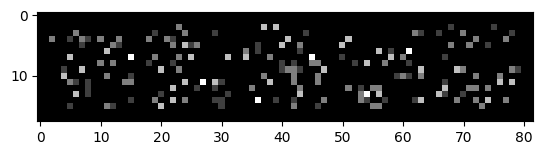

In [28]:
plt.imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))

In [14]:
loss_dict = torch.load(f"saved_models/losses.pt")

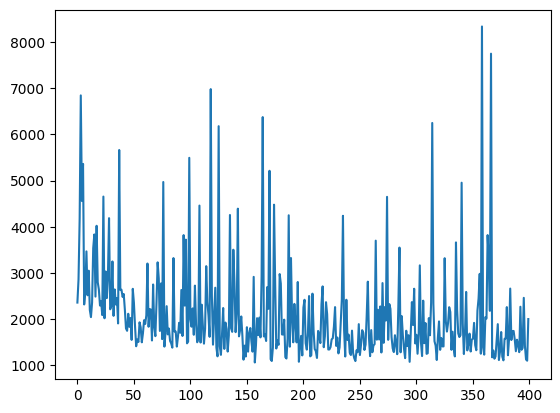

In [23]:
# plt.plot(loss_dict["train"])
plt.plot(loss_dict["test"])